In [1]:
import torch
import numpy as np
import os
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image
from pathlib import Path

In [2]:
#mount googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Year_3/APS360/APS360_project/spectrogram_genre'

batch_size = 20
num_workers = 1
classes = ['Electronic', 'Folk', 'Hip-Hop', 'Rock']
genres = os.listdir(path)

In [ ]:
torch.manual_seed(0) # set the random seed

class CNN_model(nn.Module):
    def __init__(self, csize = [32, 32, 32, 32, 32], ksize = [2, 2, 2, 2], numclasses = 4, inputdim = 3, inputsize = 128):
        super(CNN_model, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(inputdim, csize[0], ksize[0])
        self.conv2 = nn.Conv2d(csize[0], csize[1], ksize[1])
        self.conv3 = nn.Conv2d(csize[1], csize[2], ksize[2])
        self.conv4 = nn.Conv2d(csize[2], csize[3], ksize[3])
        self.pool = nn.MaxPool2d(2, 2)

        self.temp1 = int((inputsize - ksize[0] + 1)/2)
        self.temp2 = int((self.temp1 - ksize[1] + 1)/2)
        self.temp3 = int((self.temp2 - ksize[2] + 1)/2)
        self.temp4 = int((self.temp3 - ksize[3] + 1)/2)
        self.fcin = csize[3]*pow(self.temp4,2)
        self.fc1 = nn.Linear(self.fcin, csize[4])
        self.fc2 = nn.Linear(csize[4], numclasses)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, self.fcin)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path


In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform, img_label):
        self.main_dir = main_dir
        self.transform = transform
        filelist = []

        for root, dirs, files in os.walk(main_dir):
          for file in files:
            # append the file name to the listto
            filelist.append(os.path.join(root,file))
        
        all_imgs = filelist
        self.total_imgs = natsorted(all_imgs)
        self.img_labels = [img_label for i in range(len(self.total_imgs))]

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        label = self.img_labels[idx]
        return tensor_image, label

In [ ]:
# for creating dataset for the first time

# dataset = []
# i = 0

# transform = transforms.Compose([transforms.Resize((128,128)), 
#                                   transforms.ToTensor()])

# for genre in genres:
#   dataset.append(CustomDataSet(path + "/" + genre, transform, i))
#   print(path + "/" + genre)
#   print(len(dataset[i]))

#   i += 1

/content/drive/MyDrive/Year_3/APS360/APS360_project/spectrogram_genre/Electronic
10000
/content/drive/MyDrive/Year_3/APS360/APS360_project/spectrogram_genre/Folk
10000
/content/drive/MyDrive/Year_3/APS360/APS360_project/spectrogram_genre/Hip-Hop
10000
/content/drive/MyDrive/Year_3/APS360/APS360_project/spectrogram_genre/Rock
10000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


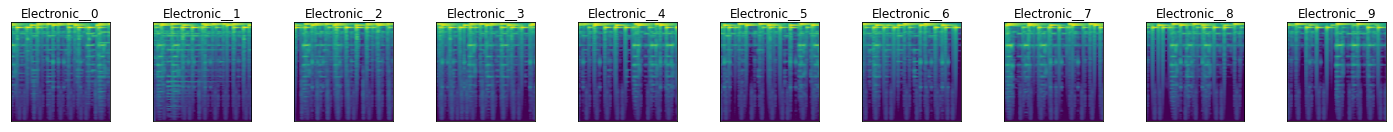

In [ ]:
# run the below code if making dataloaders for the first time

# dataloader = []

# for i in range(len(genres)):
#   dataloader_obj = torch.utils.data.DataLoader(dataset[i], batch_size=10, 
#                                                  num_workers=8)
#   torch.save(dataloader_obj, "dataloader_" + genres[i] + ".pth")
#   dataloader.append(dataloader_obj)

# # display a sample
# dataiter = iter(dataloader[0])
# images, labels = dataiter.next()
# images = images.numpy() # convert images to numpy for display

# # plot the images in the batch, along with the corresponding labels
# fig = plt.figure(figsize=(25, 4))
# for idx in np.arange(10):
#     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#     plt.imshow(np.transpose(images[idx], (1, 2, 0)))
#     ax.set_title(genres[labels[idx]] + "_" + str(idx)[:-1]+ "_" + str(idx)[-1])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


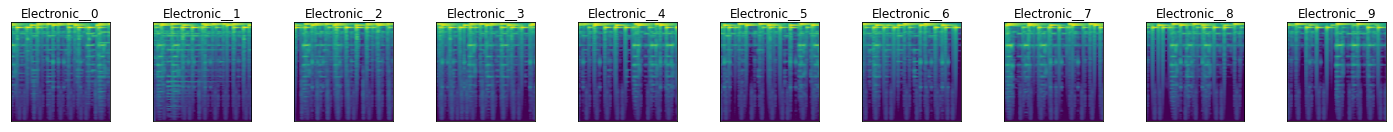

In [ ]:
dataloader = []

for genre in genres:
  dataloader_path = '/content/drive/MyDrive/Year_3/APS360/APS360_project/spectrogram_dataloaders'
  dataloader.append(torch.load(dataloader_path + '/dataloader_' + genre + '.pth'))

dataiter = iter(dataloader[0])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(genres[labels[idx]] + "_" + str(idx)[:-1]+ "_" + str(idx)[-1])

In [ ]:
def save_statistics(label, song_pred, slice_pred, df):
  # label is list of tensor of 1 number
  # song_pred is list of tensor of 1 number
  # slice_pred is tensor of array size 10
  # df is pd dataframe to append

  return df.append({"label": label[0].detach().item(), 
                    "song_pred": song_pred[0].detach().item(), 
                    "pred_0": np.count_nonzero(slice_pred.detach().numpy() == 0),
                    "pred_1": np.count_nonzero(slice_pred.detach().numpy() == 1),
                    "pred_2": np.count_nonzero(slice_pred.detach().numpy() == 2),
                    "pred_3": np.count_nonzero(slice_pred.detach().numpy() == 3),},
                   ignore_index=True)

In [ ]:
label = [torch.tensor(2)]
song_pred = [torch.tensor(2)]
slice_pred = torch.tensor([2, 2, 1, 1, 1, 0, 0, 0, 3, 3])

df = pd.DataFrame(columns=["label", "song_pred", "pred_0", "pred_1", "pred_2", "pred_3"])

save_statistics(label, song_pred, slice_pred, df)

,label,song_pred,pred_0,pred_1,pred_2,pred_3
0,2,2,3,3,2,2


In [ ]:
import statistics
from statistics import mode

def evaluate_voting(model, data_loader, df):
    correct = 0
    total = 0
    
    print("Number correct:")

    for imgs, labels in data_loader:        
        # if torch.cuda.is_available():
        #   imgs = imgs.cuda()
        #   labels = labels.cuda()

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1].detach()

        # take the majority vote as the final one
        final_pred = []
        final_labels = []

        for start_idx in range(0,len(pred),10):
          slice_pred = torch.cat(pred[start_idx:start_idx+10].unbind())
          song_pred = torch.mode(slice_pred,0)[0]
          final_pred.append(song_pred)
          final_labels.append(labels[start_idx])

          # print(f"\tPredictions for song: {slice_pred}")
          # print(f"\tMode: {song_pred}")
          # print(f"\tPredicted genre for song: {genres[song_pred]}")
          # print(f"\tActual genre for song: {genres[labels[start_idx]]}")
        # check correctness
        correct += (final_pred == final_labels)
        total += imgs.shape[0]//10

        print(f"\t{correct} of {total} ({correct/total*100:.3f}%)")
        print(f"\t\tPredictions for slices: {slice_pred}")
        print(f"\t\tFinal predictions: {final_pred}")
        print(f"\t\tFinal labels: \t{final_labels}")
        df = save_statistics(final_labels, final_pred, slice_pred, df)

    return correct / total, df

In [ ]:
# === VOTING MODEL ===
model = CNN_model()
saved_state = '/content/drive/MyDrive/APS360_project/saved states/FULLmodel_CNN_epoch9_valacc0.6725'
model.load_state_dict(torch.load(saved_state, map_location=torch.device('cpu')))
test_acc = []
df = pd.DataFrame(columns=["label", "song_pred", "pred_0", "pred_1", "pred_2", "pred_3"])

for genre_set in np.arange(4):
  acc, df = evaluate_voting(model, dataloader[genre_set], df)
  test_acc.append(acc)
  print(f"Accuracy for {genres[genre_set]}: {test_acc[genre_set]}")

Number correct:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Streaming output truncated to the last 5000 lines.
		Final labels: 	[tensor(2)]
	582 of 752 (77.394%)
		Predictions for slices: tensor([2, 2, 2, 3, 0, 0, 0, 0, 0, 0])
		Final predictions: [tensor(0)]
		Final labels: 	[tensor(2)]
	583 of 753 (77.424%)
		Predictions for slices: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
		Final predictions: [tensor(2)]
		Final labels: 	[tensor(2)]
	584 of 754 (77.454%)
		Predictions for slices: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
		Final predictions: [tensor(2)]
		Final labels: 	[tensor(2)]
	585 of 755 (77.483%)
		Predictions for slices: tensor([2, 2, 2, 2, 2, 2, 0, 2, 2, 2])
		Final predictions: [tensor(2)]
		Final labels: 	[tensor(2)]
	586 of 756 (77.513%)
		Predictions for slices: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
		Final predictions: [tensor(2)]
		Final labels: 	[tensor(2)]
	587 of 757 (77.543%)
		Predictions for slices: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
		Final predictions: [tensor(2)]
		Final labels: 	[tensor(2)]
	588 of 758 (77.573%)
		Pr

,label,song_pred,pred_0,pred_1,pred_2,pred_3
0,0,0,6,1,0,3
1,0,0,6,0,1,3
2,0,1,1,7,0,2
3,0,1,1,4,1,4
4,0,0,7,0,2,1
...,...,...,...,...,...,...
3995,3,3,0,0,0,10
3996,3,3,0,0,0,10
3997,3,0,6,0,1,3
3998,3,3,0,0,0,10


In [ ]:
# === VOTING MODEL (old output) ===
# model = CNN_model()
# saved_state = '/content/drive/MyDrive/Year_3/APS360/APS360_project/saved states/model_CNN_bs4_lr0.001_epoch0_45'
# model.load_state_dict(torch.load(saved_state, map_location=torch.device('cpu')))
# test_acc = []

# for genre_set in np.arange(4):
#   test_acc.append(evaluate_voting(model, dataloader[genre_set]))
#   print(f"Accuracy for {genres[genre_set]}: {test_acc[genre_set]}")

Number correct:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Streaming output truncated to the last 5000 lines.
		Final labels: 	[tensor(2)]
	117 of 752 (15.559%)
		Predictions for slices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
		Final predictions: [tensor(0)]
		Final labels: 	[tensor(2)]
	117 of 753 (15.538%)
		Predictions for slices: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
		Final predictions: [tensor(1)]
		Final labels: 	[tensor(2)]
	118 of 754 (15.650%)
		Predictions for slices: tensor([0, 2, 2, 2, 2, 0, 2, 2, 0, 2])
		Final predictions: [tensor(2)]
		Final labels: 	[tensor(2)]
	118 of 755 (15.629%)
		Predictions for slices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
		Final predictions: [tensor(0)]
		Final labels: 	[tensor(2)]
	118 of 756 (15.608%)
		Predictions for slices: tensor([1, 0, 0, 0, 1, 0, 0, 1, 0, 0])
		Final predictions: [tensor(0)]
		Final labels: 	[tensor(2)]
	118 of 757 (15.588%)
		Predictions for slices: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
		Final predictions: [tensor(0)]
		Final labels: 	[tensor(2)]
	118 of 758 (15.567%)
		Pr

In [ ]:
import pandas as pd
genre_accuracy = pd.DataFrame(data={'genre': genres, 'voting_accuracy': test_acc})

genre_accuracy

,genre,voting_accuracy
0,Electronic,0.497
1,Folk,0.825
2,Hip-Hop,0.773
3,Rock,0.776


In [ ]:
df.to_csv('/content/drive/MyDrive/Year_3/APS360/APS360_project/Final Report/result.csv', index=False)
df

,label,song_pred,pred_0,pred_1,pred_2,pred_3
0,0,0,6,1,0,3
1,0,0,6,0,1,3
2,0,1,1,7,0,2
3,0,1,1,4,1,4
4,0,0,7,0,2,1
...,...,...,...,...,...,...
3995,3,3,0,0,0,10
3996,3,3,0,0,0,10
3997,3,0,6,0,1,3
3998,3,3,0,0,0,10


In [ ]:
df.groupby("label").sum().drop(["song_pred"], 1)

,pred_0,pred_1,pred_2,pred_3
label,,,,
0,4392,1399,2758,1451
1,549,7602,465,1384
2,1430,649,7164,757
3,546,1404,576,7474


In [3]:
test = pd.read_csv('/content/drive/MyDrive/Year_3/APS360/APS360_project/Final Report/result.csv')
test

,label,song_pred,pred_0,pred_1,pred_2,pred_3
0,0,0,6,1,0,3
1,0,0,6,0,1,3
2,0,1,1,7,0,2
3,0,1,1,4,1,4
4,0,0,7,0,2,1
...,...,...,...,...,...,...
3995,3,3,0,0,0,10
3996,3,3,0,0,0,10
3997,3,0,6,0,1,3
3998,3,3,0,0,0,10


In [17]:
pd.DataFrame(test[test.label == 0].sum().drop(["label", "song_pred"])).T

,pred_0,pred_1,pred_2,pred_3
0,4392,1399,2758,1451


In [19]:
pd.DataFrame(test[test.label == 1].sum().drop(["label", "song_pred"])).T

,pred_0,pred_1,pred_2,pred_3
0,549,7602,465,1384


In [20]:
pd.DataFrame(test[test.label == 2].sum().drop(["label", "song_pred"])).T

,pred_0,pred_1,pred_2,pred_3
0,1430,649,7164,757


In [22]:
pd.DataFrame(test[test.label == 3].sum().drop(["label", "song_pred"])).T

,pred_0,pred_1,pred_2,pred_3
0,546,1404,576,7474


In [ ]:
# the model will have been trained on the original spectrogram data, which has genre folders where individual spectrograms are present
# so it will predict a number betwen 0-3 (four different genres) as the label, this is a numerical output

# what we want to do is we want to iterate through the new spectrogram_genre folder and feed these into the model to get predictions
# we will not use the imagefolder dataloader since it can't use nested folders (I think)
# we will get the model's predictions for each of the songs by implementing the voting thing across the 10 samples

# iterate loop over all songs in all genres
